# Code analysis D-NeRF
- Jupyter file made only one file..!!
- Kyujin Han Made it
- You can fully understand code, because I wrote many comments.

#### References
https://github.com/albertpumarola/D-NeRF

# 1. Import Module

In [1]:
# 1. Import Module
import os
import imageio
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import json
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm, trange

try:
    from apex import amp
except ImportError:
    pass

In [2]:
# Just option
torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
DEBUG = False

# Metrics for evaluation
img2mse = lambda x, y : torch.mean((x - y) ** 2) # This is loss function.
mse2psnr = lambda x : -10. * torch.log(x) / torch.log(torch.Tensor([10.]))
to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)

In [3]:
# define parser
def config_parser():

    import argparse
    parser = argparse.ArgumentParser()
    
    #parser.add_argument('--config', is_config_file=True, 
    #                    help='config file path')
    parser.add_argument("--expname", type=str, default = "hellwarrior",
                        help='experiment name')
    parser.add_argument("--basedir", type=str, default='./logs/', 
                        help='where to store ckpts and logs')
    parser.add_argument("--datadir", type=str, default='./data/hellwarrior/', 
                        help='input data directory')

    # training options
    parser.add_argument("--nerf_type", type=str, default="D_NeRF", help='nerf network type')
    parser.add_argument("--N_iter", type=int, default=500000,
                        help='num training iterations')
    parser.add_argument("--netdepth", type=int, default=8, 
                        help='layers in network')
    parser.add_argument("--netwidth", type=int, default=256, 
                        help='channels per layer')
    parser.add_argument("--netdepth_fine", type=int, default=8, 
                        help='layers in fine network')
    parser.add_argument("--netwidth_fine", type=int, default=256, 
                        help='channels per layer in fine network')
    parser.add_argument("--N_rand", type=int, default=32*32*4, 
                        help='batch size (number of random rays per gradient step)')
    parser.add_argument("--do_half_precision", action='store_true', default=False,
                        help='do half precision training and inference')
    parser.add_argument("--lrate", type=float, default=5e-4, 
                        help='learning rate')
    parser.add_argument("--lrate_decay", type=int, default=250, 
                        help='exponential learning rate decay (in 1000 steps)')
    parser.add_argument("--chunk", type=int, default=1024*32, 
                        help='number of rays processed in parallel, decrease if running out of memory')
    parser.add_argument("--netchunk", type=int, default=1024*64, 
                        help='number of pts sent through network in parallel, decrease if running out of memory')
    parser.add_argument("--no_batching", action='store_true', default=True,
                        help='only take random rays from 1 image at a time')
    parser.add_argument("--no_reload", action='store_true', default=True,
                        help='do not reload weights from saved ckpt')
    parser.add_argument("--ft_path", type=str, default=None, 
                        help='specific weights npy file to reload for coarse network')

    # rendering options
    parser.add_argument("--N_samples", type=int, default=64, 
                        help='number of coarse samples per ray')
    parser.add_argument("--not_zero_canonical", action='store_true', default=False,
                        help='if set zero time is not the canonic space')
    parser.add_argument("--N_importance", type=int, default=0,
                        help='number of additional fine samples per ray')
    parser.add_argument("--perturb", type=float, default=1.,
                        help='set to 0. for no jitter, 1. for jitter')
    parser.add_argument("--use_viewdirs", action='store_true', default=True,
                        help='use full 5D input instead of 3D')
    parser.add_argument("--i_embed", type=int, default=0, 
                        help='set 0 for default positional encoding, -1 for none')
    parser.add_argument("--multires", type=int, default=10, 
                        help='log2 of max freq for positional encoding (3D location)')
    parser.add_argument("--multires_views", type=int, default=4, 
                        help='log2 of max freq for positional encoding (2D direction)')
    parser.add_argument("--raw_noise_std", type=float, default=0., 
                        help='std dev of noise added to regularize sigma_a output, 1e0 recommended')
    parser.add_argument("--use_two_models_for_fine", action='store_true', default=False,
                        help='use two models for fine results')

    parser.add_argument("--render_only", action='store_true', default=False,
                        help='do not optimize, reload weights and render out render_poses path')
    parser.add_argument("--render_test", action='store_true', default=False,
                        help='render the test set instead of render_poses path')
    parser.add_argument("--render_factor", type=int, default=0, 
                        help='downsampling factor to speed up rendering, set 4 or 8 for fast preview')

    # training options
    parser.add_argument("--precrop_iters", type=int, default=0,
                        help='number of steps to train on central crops')
    parser.add_argument("--precrop_iters_time", type=int, default=0,
                        help='number of steps to train on central time')
    parser.add_argument("--precrop_frac", type=float,
                        default=.5, help='fraction of img taken for central crops')
    parser.add_argument("--add_tv_loss", action='store_true', default=False,
                        help='evaluate tv loss')
    parser.add_argument("--tv_loss_weight", type=float,
                        default=1.e-4, help='weight of tv loss')

    # dataset options
    parser.add_argument("--dataset_type", type=str, default='blender', 
                        help='options: llff / blender / deepvoxels')
    parser.add_argument("--testskip", type=int, default=2,
                        help='will load 1/N images from test/val sets, useful for large datasets like deepvoxels')

    ## deepvoxels flags
    parser.add_argument("--shape", type=str, default='greek', 
                        help='options : armchair / cube / greek / vase')

    ## blender flags
    parser.add_argument("--white_bkgd", action='store_true', default=True,
                        help='set to render synthetic data on a white bkgd (always use for dvoxels)')
    parser.add_argument("--half_res", action='store_true', default=True,
                        help='load blender synthetic data at 400x400 instead of 800x800')

    ## llff flags
    parser.add_argument("--factor", type=int, default=8, 
                        help='downsample factor for LLFF images')
    parser.add_argument("--no_ndc", action='store_true', default=True,
                        help='do not use normalized device coordinates (set for non-forward facing scenes)')
    parser.add_argument("--lindisp", action='store_true', default= False,
                        help='sampling linearly in disparity rather than depth')
    parser.add_argument("--spherify", action='store_true', default=False,
                        help='set for spherical 360 scenes')
    parser.add_argument("--llffhold", type=int, default=8, 
                        help='will take every 1/N images as LLFF test set, paper uses 8')

    # logging/saving options
    parser.add_argument("--i_print",   type=int, default=1000,
                        help='frequency of console printout and metric loggin')
    parser.add_argument("--i_img",     type=int, default=10000,
                        help='frequency of tensorboard image logging')
    parser.add_argument("--i_weights", type=int, default=100000,
                        help='frequency of weight ckpt saving')
    parser.add_argument("--i_testset", type=int, default=200000,
                        help='frequency of testset saving')
    parser.add_argument("--i_video",   type=int, default=200000,
                        help='frequency of render_poses video saving')

    return parser

# 2. Datasets
- Using blender dataset
- 'mutant'

In [4]:
# First make load_blender_dataset
def load_blender_data(basedir, half_res=False, testskip=1):
    splits = ['train', 'val', 'test']
    metas = {}
    
    # There are 3 json file
    # train, valid, test
    for s in splits:
        with open(os.path.join(basedir, 'transforms_{}.json'.format(s)), 'r') as fp:
            metas[s] = json.load(fp)

    all_imgs = []
    all_poses = []
    all_times = []
    counts = [0]
    
    # Each json file has these items
    # Camera_angle_x: It will be using, when calculating focal length
    # frame name: images name
    # time: [0,1]
    # transformation matrix: C2W(Camera to world matrix) 
    for s in splits:
        meta = metas[s]

        imgs = []
        poses = []
        times = []
        # if s=='train' or testskip==0:
        #     skip = 2  # if you remove/change this 2, also change the /2 in the times vector
        # else:
        skip = testskip
            
        for t, frame in enumerate(meta['frames'][::skip]):
            fname = os.path.join(basedir, frame['file_path'] + '.png')
            imgs.append(imageio.imread(fname))
            poses.append(np.array(frame['transform_matrix'])) # C2W append poses list.
            cur_time = frame['time'] if 'time' in frame else float(t) / (len(meta['frames'][::skip])-1) # time
            times.append(cur_time)

        assert times[0] == 0, "Time must start at 0"
        
        # blender dataset has (RGB, density)
        imgs = (np.array(imgs) / 255.).astype(np.float32)  # keep all 4 channels (RGBA)
        poses = np.array(poses).astype(np.float32) # C2W
        times = np.array(times).astype(np.float32) # t
        counts.append(counts[-1] + imgs.shape[0]) # Each datasets # of counts
        all_imgs.append(imgs)
        all_poses.append(poses)
        all_times.append(times)
    
    # i=0: train index
    # i=1: valid index
    # i=2: test index
    i_split = [np.arange(counts[i], counts[i+1]) for i in range(3)]
    
    # make one matrix(concat)
    imgs = np.concatenate(all_imgs, 0)
    poses = np.concatenate(all_poses, 0)
    times = np.concatenate(all_times, 0)
    
    H, W = imgs[0].shape[:2]
    camera_angle_x = float(meta['camera_angle_x']) # Calculate focal length 
    focal = .5 * W / np.tan(.5 * camera_angle_x) # fx, fy will be same
    
    # If you have transforms_render.json file
    if os.path.exists(os.path.join(basedir, 'transforms_{}.json'.format('render'))):
        with open(os.path.join(basedir, 'transforms_{}.json'.format('render')), 'r') as fp:
            meta = json.load(fp)
        render_poses = []
        for frame in meta['frames']:
            render_poses.append(np.array(frame['transform_matrix']))
        render_poses = np.array(render_poses).astype(np.float32)
    # Usually not have, so make rendering dataset manually
    else:
        # Need angle, phi(-30,0), radius(4.0)
        render_poses = torch.stack([pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180,180,40+1)[:-1]], 0)
    render_times = torch.linspace(0., 1., render_poses.shape[0])
    
    # Memory problem
    # Reduce image resolution
    if half_res:
        H = H//2
        W = W//2
        focal = focal/2.

        imgs_half_res = np.zeros((imgs.shape[0], H, W, 4))
        for i, img in enumerate(imgs):
            imgs_half_res[i] = cv2.resize(img, (H, W), interpolation=cv2.INTER_AREA)
        imgs = imgs_half_res
        # imgs = tf.image.resize_area(imgs, [400, 400]).numpy()

    return imgs, poses, times, render_poses, render_times, [H, W, focal], i_split

#################################################################
# Below code, when calculate arbitrary input, use this function.
trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1]]).float()

rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1]]).float()

rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1]]).float()

# Calculate C2W, using extrinsic parameters
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.Tensor(np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])) @ c2w
    return c2w

# 3. Make model
- Positional embedding
- Canonical network
- Deformation network

In [5]:
# First, positional emebedding
# Each coordinates applying [sin, cos] function.
class Embedder:
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.create_embedding_fn() # function below
        
    def create_embedding_fn(self):
        embed_fns = []
        d = self.kwargs['input_dims'] # input dimension
        out_dim = 0
        if self.kwargs['include_input']: # If you want the original (x,y,z) coordinates
            embed_fns.append(lambda x : x)
            out_dim += d # Usually, 3
        
        # max_freq_log2: L-1
        # N_freqs: L
        max_freq = self.kwargs['max_freq_log2']
        N_freqs = self.kwargs['num_freqs']
        
        # If you make positional embedding method using paper's method
        # 1, 2, 4, 8, 16, ...
        if self.kwargs['log_sampling']:
            freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)
            
        # It just linear method
        # Spacing is not equal
        else:
            freq_bands = torch.linspace(2.**0., 2.**max_freq, steps=N_freqs)
        
        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']: # self.kwargs['periodic_fns'] = [torch.sin, torch.cos]
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(x * freq)) # make function
                out_dim += d # Usually 63 or 63
                    
        self.embed_fns = embed_fns
        self.out_dim = out_dim # Usually 60 or 63
    
    # Make applying positional embedding function
    def embed(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], -1)

# get embedding function
def get_embedder(multires, input_dims, i=0):
    if i == -1:
        return nn.Identity(), input_dims
    
    embed_kwargs = {
                'include_input' : True,
                'input_dims' : input_dims,
                'max_freq_log2' : multires-1,
                'num_freqs' : multires,
                'log_sampling' : True,
                'periodic_fns' : [torch.sin, torch.cos],
    }
    
    embedder_obj = Embedder(**embed_kwargs)
    embed = lambda x, eo=embedder_obj : eo.embed(x)
    return embed, embedder_obj.out_dim

In [6]:
# Second, make model network

# First, NeRF original.
# It is Canonical network
class NeRFOriginal(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, input_ch_time=1, output_ch=4, skips=[4],
                 use_viewdirs=False, memory=[], embed_fn=None, output_color_ch=3, zero_canonical=True):
        super(NeRFOriginal, self).__init__()
        self.D = D
        self.W = W
        self.input_ch = input_ch # Almost 63 or 60
        self.input_ch_views = input_ch_views # Almost 27 or 24
        self.skips = skips # Where input again (x,y,z)
        self.use_viewdirs = use_viewdirs # Boolean

        # self.pts_linears = nn.ModuleList(
        #     [nn.Linear(input_ch, W)] +
        #     [nn.Linear(W, W) if i not in self.skips else nn.Linear(W + input_ch, W) for i in range(D-1)])
        
        # Make linear function
        layers = [nn.Linear(input_ch, W)]
        for i in range(D - 1):
            if i in memory:
                raise NotImplementedError
            else:
                layer = nn.Linear

            in_channels = W
            # If next linear input again (x,y,z) n-dimension.
            if i in self.skips:
                in_channels += input_ch # 256 + 63 or 60

            layers += [layer(in_channels, W)]
        
        self.pts_linears = nn.ModuleList(layers) # until, before density output layer.

        self.views_linears = nn.ModuleList([nn.Linear(input_ch_views + W, W//2)]) # input view directions and next linear is 128
        
        # Almost we using.
        if use_viewdirs: 
            self.feature_linear = nn.Linear(W, W) # 256 -> 256 (density output stage)
            self.alpha_linear = nn.Linear(W, 1) # Output: Density
            self.rgb_linear = nn.Linear(W//2, output_color_ch) # Output: RGB
        else:
            self.output_linear = nn.Linear(W, output_ch)
    
    # Canonical space not using t variables.
    # x shape: [N, Coordinates_positional_embedding + View_directions_positional_embedding]
    def forward(self, x, ts):
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1) # So, must split
        h = input_pts
        for i, l in enumerate(self.pts_linears):
            h = self.pts_linears[i](h)
            h = F.relu(h)
            if i in self.skips: # input again (x,y,z)
                h = torch.cat([input_pts, h], -1)

        if self.use_viewdirs:
            alpha = self.alpha_linear(h) # Density
            feature = self.feature_linear(h)
            h = torch.cat([feature, input_views], -1)

            for i, l in enumerate(self.views_linears):
                h = self.views_linears[i](h)
                h = F.relu(h)

            rgb = self.rgb_linear(h) # RGB
            outputs = torch.cat([rgb, alpha], -1) # concat, make 4-dimension
        else:
            outputs = self.output_linear(h)

        return outputs, torch.zeros_like(input_pts[:, :3])

    def load_weights_from_keras(self, weights):
        assert self.use_viewdirs, "Not implemented if use_viewdirs=False"

        # Load pts_linears
        for i in range(self.D):
            idx_pts_linears = 2 * i
            self.pts_linears[i].weight.data = torch.from_numpy(np.transpose(weights[idx_pts_linears]))
            self.pts_linears[i].bias.data = torch.from_numpy(np.transpose(weights[idx_pts_linears+1]))

        # Load feature_linear
        idx_feature_linear = 2 * self.D
        self.feature_linear.weight.data = torch.from_numpy(np.transpose(weights[idx_feature_linear]))
        self.feature_linear.bias.data = torch.from_numpy(np.transpose(weights[idx_feature_linear+1]))

        # Load views_linears
        idx_views_linears = 2 * self.D + 2
        self.views_linears[0].weight.data = torch.from_numpy(np.transpose(weights[idx_views_linears]))
        self.views_linears[0].bias.data = torch.from_numpy(np.transpose(weights[idx_views_linears+1]))

        # Load rgb_linear
        idx_rbg_linear = 2 * self.D + 4
        self.rgb_linear.weight.data = torch.from_numpy(np.transpose(weights[idx_rbg_linear]))
        self.rgb_linear.bias.data = torch.from_numpy(np.transpose(weights[idx_rbg_linear+1]))

        # Load alpha_linear
        idx_alpha_linear = 2 * self.D + 6
        self.alpha_linear.weight.data = torch.from_numpy(np.transpose(weights[idx_alpha_linear]))
        self.alpha_linear.bias.data = torch.from_numpy(np.transpose(weights[idx_alpha_linear+1]))
        
        
#################################################
# Second, make Deformation network
# And D-NeRF class function
class DirectTemporalNeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, input_ch_time=1, output_ch=4, skips=[4],
                 use_viewdirs=False, memory=[], embed_fn=None, zero_canonical=True):
        super(DirectTemporalNeRF, self).__init__()
        # Also same Canonocial network
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views 
        self.input_ch_time = input_ch_time
        self.skips = skips
        self.use_viewdirs = use_viewdirs
        self.memory = memory
        self.embed_fn = embed_fn # positional embedding function
        self.zero_canonical = zero_canonical # Boolean, If you want not using t=0, false. // Almost True
        
        # Canonical network
        self._occ = NeRFOriginal(D=D, W=W, input_ch=input_ch, input_ch_views=input_ch_views,
                                 input_ch_time=input_ch_time, output_ch=output_ch, skips=skips,
                                 use_viewdirs=use_viewdirs, memory=memory, embed_fn=embed_fn, output_color_ch=3)
        
        #  # Create deformation network
        self._time, self._time_out = self.create_deformation_net()
    
    # The structure almost same the Canonical network
    def create_deformation_net(self):
        layers = [nn.Linear(self.input_ch + self.input_ch_time, self.W)]
        for i in range(self.D - 1):
            if i in self.memory:
                raise NotImplementedError
            else:
                layer = nn.Linear

            in_channels = self.W
            if i in self.skips: 
                in_channels += self.input_ch # 256 + 63 or 60
            
            layers += [layer(in_channels, self.W)]
        return nn.ModuleList(layers), nn.Linear(self.W, 3)
    
    # implementation deformation network
    def deformation_network_imp(self, new_pts, t, net, net_final):
        h = torch.cat([new_pts, t], dim=-1) # Dimension ==> new_pts: 60 or 63 // t: 10 or 11
        for i, l in enumerate(net):
            h = net[i](h)
            h = F.relu(h)
            if i in self.skips:
                h = torch.cat([new_pts, h], -1)

        return net_final(h)

    def forward(self, x, ts):
        # X will be concat, the X positional embedding and View directions positional embedding
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1)
        
        # N: The number of t is sampling number.
        # 10 or 11: positional embedding
        t = ts[0] # t's shape [N,10 or 11] 

        # Must same! Because, D-NeRF sampling cooridnate in one image.
        assert len(torch.unique(t[:, :1])) == 1, "Only accepts all points from same time" 
        
        cur_time = t[0, 0]
        if cur_time == 0. and self.zero_canonical: # If t = 0
            dx = torch.zeros_like(input_pts[:, :3]) # dx = 0
            
        else:
            dx = self.deformation_network_imp(input_pts, t, self._time, self._time_out) # Deformation network
            input_pts_orig = input_pts[:, :3] # (x,y,z)
            input_pts = self.embed_fn(input_pts_orig + dx) # (x+dx, y+dx, z+dx) applying position embedding
            
        # out = [RGB. density] 4-dimension
        out, _ = self._occ(torch.cat([input_pts, input_views], dim=-1), t) # And input above this. 
        return out, dx
    

###########################################
# Third, Make all NeRF class
class NeRF:
    @staticmethod
    def get_by_name(type,  *args, **kwargs):
        print ("NeRF type selected: %s" % type)

        if type == "original":
            model = NeRFOriginal(*args, **kwargs)
        elif type == "D_NeRF": # almost we using this.
            model = DirectTemporalNeRF(*args, **kwargs)
        else:
            raise ValueError("Type %s not recognized." % type)
        return model

# 4. Make rendering and some function
- create_nerf
- run_network
- batchify
- render_path
- get_rays
- ndc_rays
- render
- batchify_rays
- render_rays
- sample_pdf
- raw2outputs

In [7]:
# First, make D_NeRF model.
def create_nerf(args):
    """Instantiate NeRF's MLP model.
    """
    # First get embedding
    # args.multires = L
    # args.i_embed = Do you want positional embedding?
    embed_fn, input_ch = get_embedder(args.multires, 3, args.i_embed)
    embedtime_fn, input_ch_time = get_embedder(args.multires, 1, args.i_embed) # t positional embedding. L=10

    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(args.multires_views, 3, args.i_embed) # L = 8. view directions

    # N_importance: Do you use Fine network?
    output_ch = 5 if args.N_importance > 0 else 4
    skips = [4]
    # Make D-NeRF
    model = NeRF.get_by_name(args.nerf_type, D=args.netdepth, W=args.netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, input_ch_time=input_ch_time,
                 use_viewdirs=args.use_viewdirs, embed_fn=embed_fn,
                 zero_canonical=not args.not_zero_canonical).to(device)
    grad_vars = list(model.parameters()) # save coarse network

    model_fine = None
    if args.use_two_models_for_fine: # using fine network
        model_fine = NeRF.get_by_name(args.nerf_type, D=args.netdepth_fine, W=args.netwidth_fine,
                          input_ch=input_ch, output_ch=output_ch, skips=skips,
                          input_ch_views=input_ch_views, input_ch_time=input_ch_time,
                          use_viewdirs=args.use_viewdirs, embed_fn=embed_fn,
                          zero_canonical=not args.not_zero_canonical).to(device)
        grad_vars += list(model_fine.parameters()) # save fine network // So, D-NeRF is end-to-end training method.

    # training lambda function
    network_query_fn = lambda inputs, viewdirs, ts, network_fn : run_network(inputs, viewdirs, ts, network_fn,
                                                                embed_fn=embed_fn,
                                                                embeddirs_fn=embeddirs_fn,
                                                                embedtime_fn=embedtime_fn,
                                                                netchunk=args.netchunk,
                                                                embd_time_discr=args.nerf_type!="temporal")

    # Create optimizer
    optimizer = torch.optim.Adam(params=grad_vars, lr=args.lrate, betas=(0.9, 0.999))

    if args.do_half_precision:
        print("Run model at half precision")
        if model_fine is not None:
            [model, model_fine], optimizers = amp.initialize([model, model_fine], optimizer, opt_level='O1')
        else:
            model, optimizers = amp.initialize(model, optimizer, opt_level='O1')

    start = 0
    basedir = args.basedir
    expname = args.expname

    ##########################

    # Load checkpoints
    if args.ft_path is not None and args.ft_path!='None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload:
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step']
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict'])
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict'])
        if args.do_half_precision:
            amp.load_state_dict(ckpt['amp'])

    ##########################
    # Make train dictinoary
    render_kwargs_train = {
        'network_query_fn' : network_query_fn,
        'perturb' : args.perturb,
        'N_importance' : args.N_importance,
        'network_fine': model_fine,
        'N_samples' : args.N_samples,
        'network_fn' : model,
        'use_viewdirs' : args.use_viewdirs,
        'white_bkgd' : args.white_bkgd,
        'raw_noise_std' : args.raw_noise_std,
        'use_two_models_for_fine' : args.use_two_models_for_fine,
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp
    
    # Make test dictinoary
    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False # Using stratified samples
    render_kwargs_test['raw_noise_std'] = 0. # Not using noise (You can see the option in raw2outputs function.)
    
    # grad_vars: gradient parameters
    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer

#########################################
# Second, run_network function
# In using, network_query_fn function.
def run_network(inputs, viewdirs, frame_time, fn, embed_fn, embeddirs_fn, embedtime_fn, netchunk=1024*64,
                embd_time_discr=True):
    """Prepares inputs and applies network 'fn'.
    inputs: N_rays x N_points_per_ray x 3
    viewdirs: N_rays x 3
    frame_time: N_rays x 1
    """
    assert len(torch.unique(frame_time)) == 1, "Only accepts all points from same time"
    cur_time = torch.unique(frame_time)[0]

    # embed position
    inputs_flat = torch.reshape(inputs, [-1, inputs.shape[-1]]) # [N_rays, N_samping, 3] -> [-1, 3]
    embedded = embed_fn(inputs_flat)

    # embed time
    if embd_time_discr:
        B, N, _ = inputs.shape
        # time shape: [N_rays,]
        input_frame_time = frame_time[:, None].expand([B, N, 1]) 
        input_frame_time_flat = torch.reshape(input_frame_time, [-1, 1])
        embedded_time = embedtime_fn(input_frame_time_flat)
        embedded_times = [embedded_time, embedded_time]

    else:
        assert NotImplementedError

    # embed views
    if viewdirs is not None:
        # directions shape: [N_rays, 3]
        input_dirs = viewdirs[:,None].expand(inputs.shape)
        input_dirs_flat = torch.reshape(input_dirs, [-1, input_dirs.shape[-1]])
        embedded_dirs = embeddirs_fn(input_dirs_flat)
        embedded = torch.cat([embedded, embedded_dirs], -1) # [N_rays*N_sampling, pts+viewdirections]
    
    # fn: network_fn(D_NeRF)
    outputs_flat, position_delta_flat = batchify(fn, netchunk)(embedded, embedded_times)
    outputs = torch.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]])
    position_delta = torch.reshape(position_delta_flat, list(inputs.shape[:-1]) + [position_delta_flat.shape[-1]])
    return outputs, position_delta

##########################################
# Third, using chunk
# It prevents memory over problem(?)
def batchify(fn, chunk):
    """Constructs a version of 'fn' that applies to smaller batches.
    """
    if chunk is None:
        return fn
    def ret(inputs_pos, inputs_time):
        num_batches = inputs_pos.shape[0]

        out_list = []
        dx_list = []
        for i in range(0, num_batches, chunk):
             # Limitation input: the number of chunk
            # Total: N_rays * N_sampling
            # In run_network, chunk = 1024*64
            # coordinates sampling
            out, dx = fn(inputs_pos[i:i+chunk], [inputs_time[0][i:i+chunk], inputs_time[1][i:i+chunk]])
            out_list += [out] # [rgb, density]
            dx_list += [dx] # delta_x
        return torch.cat(out_list, 0), torch.cat(dx_list, 0)
    return ret

In [8]:
# Fourth volume rendering.
# args.render_only = True
def render_path(render_poses, render_times, hwf, chunk, render_kwargs, gt_imgs=None, savedir=None,
                render_factor=0, save_also_gt=False, i_offset=0):
    
    # hwf get the load_blender_data: [H, W, focal]
    H, W, focal = hwf

    # low resolution
    if render_factor!=0:
        # Render downsampled for speed
        H = H//render_factor
        W = W//render_factor
        focal = focal/render_factor

    if savedir is not None:
        save_dir_estim = os.path.join(savedir, "estim")
        save_dir_gt = os.path.join(savedir, "gt")
        if not os.path.exists(save_dir_estim):
            os.makedirs(save_dir_estim)
        if save_also_gt and not os.path.exists(save_dir_gt):
            os.makedirs(save_dir_gt)

    rgbs = []
    disps = []
    
    # render_poses: make arbitrary (theta, phi, t)
    for i, (c2w, frame_time) in enumerate(zip(tqdm(render_poses), render_times)):
        # rendring
        # rgb: rgb_map // but rgb will be 0~1 scale.
        # disp: 1/density map
        # acc: torch.sum(weights, -1) map. // Density high, acc -> 1, Density los, acc -> 0.
        # Below, i will introduce 'render' function
        rgb, disp, acc, _ = render(H, W, focal, chunk=chunk, c2w=c2w[:3,:4], frame_time=frame_time, **render_kwargs)
        rgbs.append(rgb.cpu().numpy())
        disps.append(disp.cpu().numpy())

        if savedir is not None:
            rgb8_estim = to8b(rgbs[-1]) # to8b function is rgb(0~1) => rgb(0~255)
            filename = os.path.join(save_dir_estim, '{:03d}.png'.format(i+i_offset))
            imageio.imwrite(filename, rgb8_estim)
            if save_also_gt:
                rgb8_gt = to8b(gt_imgs[i])
                filename = os.path.join(save_dir_gt, '{:03d}.png'.format(i+i_offset))
                imageio.imwrite(filename, rgb8_gt)
                
        # (kyujinpy add)
        # Memory over problem solution
        del rgb, disp, acc, _
    
    # stacking each image(frame)
    rgbs = np.stack(rgbs, 0)
    disps = np.stack(disps, 0)

    return rgbs, disps

#############################################
# TFifth, get rays function
def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))  # pytorch's meshgrid has indexing='ij'
    i = i.t()
    j = j.t()
    dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1) # Cx = 0.5*w, Cy = 0.5*H
    # Rotate ray directions from camera frame to the world frame
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = c2w[:3,-1].expand(rays_d.shape)
    return rays_o, rays_d

# Using the llff dataset or real forward facing scene dataset.
def ndc_rays(H, W, focal, near, rays_o, rays_d):
    # Shift ray origins to near plane
    t = -(near + rays_o[...,2]) / rays_d[...,2]
    rays_o = rays_o + t[...,None] * rays_d
    
    # Projection
    o0 = -1./(W/(2.*focal)) * rays_o[...,0] / rays_o[...,2]
    o1 = -1./(H/(2.*focal)) * rays_o[...,1] / rays_o[...,2]
    o2 = 1. + 2. * near / rays_o[...,2]

    d0 = -1./(W/(2.*focal)) * (rays_d[...,0]/rays_d[...,2] - rays_o[...,0]/rays_o[...,2])
    d1 = -1./(H/(2.*focal)) * (rays_d[...,1]/rays_d[...,2] - rays_o[...,1]/rays_o[...,2])
    d2 = -2. * near / rays_o[...,2]
    
    rays_o = torch.stack([o0,o1,o2], -1)
    rays_d = torch.stack([d0,d1,d2], -1)
    
    return rays_o, 

#############################################
# Sixth, more detail volume rendering code
def render(H, W, focal, chunk=1024*32, rays=None, c2w=None, ndc=True,
                  near=0., far=1., frame_time=None,
                  use_viewdirs=False, c2w_staticcam=None,
                  **kwargs):
    """Render rays
    Args:
      H: int. Height of image in pixels.
      W: int. Width of image in pixels.
      focal: float. Focal length of pinhole camera.
      chunk: int. Maximum number of rays to process simultaneously. Used to
        control maximum memory usage. Does not affect final results.
      rays: array of shape [2, batch_size, 3]. Ray origin and direction for
        each example in batch.
      c2w: array of shape [3, 4]. Camera-to-world transformation matrix.
      ndc: bool. If True, represent ray origin, direction in NDC coordinates.
      near: float or array of shape [batch_size]. Nearest distance for a ray.
      far: float or array of shape [batch_size]. Farthest distance for a ray.
      use_viewdirs: bool. If True, use viewing direction of a point in space in model.
      c2w_staticcam: array of shape [3, 4]. If not None, use this transformation matrix for 
       camera while using other c2w argument for viewing directions.
    Returns:
      rgb_map: [batch_size, 3]. Predicted RGB values for rays.
      disp_map: [batch_size]. Disparity map. Inverse of depth.
      acc_map: [batch_size]. Accumulated opacity (alpha) along a ray.
      extras: dict with everything returned by render_rays().
    """
    if c2w is not None:
        # special case to render full image
        rays_o, rays_d = get_rays(H, W, focal, c2w) # almost using. c2w = transformation_matrix in json file.
        
    else:
        # use provided ray batch
        rays_o, rays_d = rays

    if use_viewdirs:
        # provide ray directions as input
        viewdirs = rays_d
        if c2w_staticcam is not None:
            # special case to visualize effect of viewdirs
            rays_o, rays_d = get_rays(H, W, focal, c2w_staticcam)
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True) # Normalize. Because made -> magnitue 1.
        viewdirs = torch.reshape(viewdirs, [-1,3]).float() # [N_rays, 3]

    sh = rays_d.shape # [..., 3]
    # Using llff, forward facing scene dataset.
    if ndc:
        # for forward facing scenes
        rays_o, rays_d = ndc_rays(H, W, focal, 1., rays_o, rays_d)

    # Create ray batch
    # rays_o: [H, W, 3]
    # rays_d: [H, W, 3]
    rays_o = torch.reshape(rays_o, [-1,3]).float() # [N_rays, 3]
    rays_d = torch.reshape(rays_d, [-1,3]).float() # [N_rays, 3]
    
    # Set near, far 
    # (set rays minimum and maximum)
    near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])
    frame_time = frame_time * torch.ones_like(rays_d[...,:1])
    rays = torch.cat([rays_o, rays_d, near, far, frame_time], -1)
    
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], -1)
    # rays = [N_rays, ray_o(3)+rays_d(3)+near(1)+far(!)+frame_time(!)+viewdirs(3)] ==> [N_rays, 12]

    # Render and reshape
    # chunk: prevents memory over problem. Set input sampling number.
    all_ret = batchify_rays(rays, chunk, **kwargs)
    for k in all_ret:
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = torch.reshape(all_ret[k], k_sh)
    
    # Output
    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]

###################################
# Seventh, make batch(?) and training.
# Ray sampling
def batchify_rays(rays_flat, chunk=1024*32, **kwargs):
    """Render rays in smaller minibatches to avoid OOM.
    """
    all_ret = {}
    for i in range(0, rays_flat.shape[0], chunk):
        # Total: H*W (400*400)
        # The limitation rays input 1024*32.
        ret = render_rays(rays_flat[i:i+chunk], **kwargs)
        for k in ret:
            if k not in all_ret:
                all_ret[k] = []
            all_ret[k].append(ret[k])

    all_ret = {k : torch.cat(all_ret[k], 0) for k in all_ret}
    return all_ret

###################################################
# Eighth, render_rays function.
# Very important function
# Training
# Coordinate sampling
def render_rays(ray_batch,
                network_fn,
                network_query_fn,
                N_samples,
                retraw=False,
                lindisp=False,
                perturb=0.,
                N_importance=0,
                network_fine=None,
                white_bkgd=False,
                raw_noise_std=0.,
                verbose=False,
                pytest=False,
                z_vals=None,
                use_two_models_for_fine=False):
    """Volumetric rendering.
    Args:
      ray_batch: array of shape [batch_size, ...]. All information necessary
        for sampling along a ray, including: ray origin, ray direction, min
        dist, max dist, and unit-magnitude viewing direction.
      network_fn: function. Model for predicting RGB and density at each point
        in space.
      network_query_fn: function used for passing queries to network_fn.
      N_samples: int. Number of different times to sample along each ray.
      retraw: bool. If True, include model's raw, unprocessed predictions.
      lindisp: bool. If True, sample linearly in inverse depth rather than in depth.
      perturb: float, 0 or 1. If non-zero, each ray is sampled at stratified
        random points in time.
      N_importance: int. Number of additional times to sample along each ray.
        These samples are only passed to network_fine.
      network_fine: "fine" network with same spec as network_fn.
      white_bkgd: bool. If True, assume a white background.
      raw_noise_std: ...
      verbose: bool. If True, print more debugging info.
    Returns:
      rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
      disp_map: [num_rays]. Disparity map. 1 / depth.
      acc_map: [num_rays]. Accumulated opacity along each ray. Comes from fine model.
      raw: [num_rays, num_samples, 4]. Raw predictions from model.
      rgb0: See rgb_map. Output for coarse model.
      disp0: See disp_map. Output for coarse model.
      acc0: See acc_map. Output for coarse model.
      z_std: [num_rays]. Standard deviation of distances along ray for each
        sample.
    """
    
    # We remember
    # rays = [N_rays, ray_o(3)+rays_d(3)+near(1)+far(!)+frame_time(!)+viewdirs(3)] ==> [N_rays, 12]
    # N_rays: default 1024*32
    # Each rays, has z locations // Coarse network: 64, Fine network: 128 (Default)

    N_rays = ray_batch.shape[0]
    rays_o, rays_d = ray_batch[:,0:3], ray_batch[:,3:6] # [N_rays, 3] each
    viewdirs = ray_batch[:,-3:] if ray_batch.shape[-1] > 9 else None
    bounds = torch.reshape(ray_batch[...,6:9], [-1,1,3]) # near, far, time
    near, far, frame_time = bounds[...,0], bounds[...,1], bounds[...,2]
    z_samples = None
    rgb_map_0, disp_map_0, acc_map_0, position_delta_0 = None, None, None, None
    
    # Calculate sampling z location
    if z_vals is None:
        t_vals = torch.linspace(0., 1., steps=N_samples) # N_samples: the number of sampling coordinates.
        
        # Trianing time we used it.
        if not lindisp:
            z_vals = near * (1.-t_vals) + far * (t_vals) # Make z location in rays direction
        else:
            z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

        z_vals = z_vals.expand([N_rays, N_samples]) # [N_rays, N_samples]
    
        # stratified samples
        # Nc sampling
        if perturb > 0.:
            # get intervals between samples
            mids = .5 * (z_vals[...,1:] + z_vals[...,:-1]) # [N_rays, N_samples-1]
            upper = torch.cat([mids, z_vals[...,-1:]], -1) # Upper bound
            lower = torch.cat([z_vals[...,:1], mids], -1) # Lower bound
            # stratified samples in those intervals
            t_rand = torch.rand(z_vals.shape) # N_rays, N_samples]

            # Pytest, overwrite u with numpy's fixed random numbers
            # Not using
            if pytest:
                np.random.seed(0)
                t_rand = np.random.rand(*list(z_vals.shape))
                t_rand = torch.Tensor(t_rand)
            
            # Choose z location
            z_vals = lower + (upper - lower) * t_rand
        
        # Make (x,y,z)
        # o + td
        pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples, 3]

        # Not use fine network
        if N_importance <= 0:
            raw, position_delta = network_query_fn(pts, viewdirs, frame_time, network_fn)
            # Below, i will introduce 'raw2outputs' function
            rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

        else:
            # use two coarse networks and use fine network
            # False boolean
            if use_two_models_for_fine:
                raw, position_delta_0 = network_query_fn(pts, viewdirs, frame_time, network_fn)
                rgb_map_0, disp_map_0, acc_map_0, weights, _ = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)

            else:
                # not training(?)
                with torch.no_grad():
                    raw, _ = network_query_fn(pts, viewdirs, frame_time, network_fn)
                    _, _, _, weights, _ = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)
            
            # Nf sampling
            z_vals_mid = .5 * (z_vals[...,1:] + z_vals[...,:-1])
            # Using the coarse network weights
            z_samples = sample_pdf(z_vals_mid, weights[...,1:-1], N_importance, det=(perturb==0.), pytest=pytest) # PDF, CDF
            z_samples = z_samples.detach()
            z_vals, _ = torch.sort(torch.cat([z_vals, z_samples], -1), -1)
    
    # Make again (x,y,z)
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None] # [N_rays, N_samples + N_importance, 3]
    # Fine network
    run_fn = network_fn if network_fine is None else network_fine
    raw, position_delta = network_query_fn(pts, viewdirs, frame_time, run_fn)
    rgb_map, disp_map, acc_map, weights, _ = raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest=pytest)
    
    # Make output
    ret = {'rgb_map' : rgb_map, 'disp_map' : disp_map, 'acc_map' : acc_map, 'z_vals' : z_vals,
           'position_delta' : position_delta}
    if retraw:
        ret['raw'] = raw
    if N_importance > 0:
        if rgb_map_0 is not None:
            ret['rgb0'] = rgb_map_0
        if disp_map_0 is not None:
            ret['disp0'] = disp_map_0
        if acc_map_0 is not None:
            ret['acc0'] = acc_map_0
        if position_delta_0 is not None:
            ret['position_delta_0'] = position_delta_0
        if z_samples is not None:
            ret['z_std'] = torch.std(z_samples, dim=-1, unbiased=False)  # [N_rays]

    for k in ret:
        if (torch.isnan(ret[k]).any() or torch.isinf(ret[k]).any()) and DEBUG:
            print(f"! [Numerical Error] {k} contains nan or inf.")
            
    # (kyujinpy add)
    # Memory over problem solution
    del rgb_map, disp_map, acc_map, weights, _

    return ret

###################################
# Ninth, sample_pdf function
# Nf sampling, and using in fine network
def sample_pdf(bins, weights, N_samples, det=False, pytest=False):
    # Get pdf
    weights = weights + 1e-5 # prevent nans
    pdf = weights / torch.sum(weights, -1, keepdim=True)
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat([torch.zeros_like(cdf[...,:1]), cdf], -1)  # (batch, len(bins))

    # Take uniform samples
    if det:
        u = torch.linspace(0., 1., steps=N_samples)
        u = u.expand(list(cdf.shape[:-1]) + [N_samples])
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [N_samples])

    # Pytest, overwrite u with numpy's fixed random numbers
    if pytest:
        np.random.seed(0)
        new_shape = list(cdf.shape[:-1]) + [N_samples]
        if det:
            u = np.linspace(0., 1., N_samples)
            u = np.broadcast_to(u, new_shape)
        else:
            u = np.random.rand(*new_shape)
        u = torch.Tensor(u)

    # Invert CDF
    u = u.contiguous()
    inds = torch.searchsorted(cdf, u, side='right')
    below = torch.max(torch.zeros_like(inds-1), inds-1)
    above = torch.min((cdf.shape[-1]-1) * torch.ones_like(inds), inds)
    inds_g = torch.stack([below, above], -1)  # (batch, N_samples, 2)

    # cdf_g = tf.gather(cdf, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)
    # bins_g = tf.gather(bins, inds_g, axis=-1, batch_dims=len(inds_g.shape)-2)
    matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]]
    cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
    bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)

    denom = (cdf_g[...,1]-cdf_g[...,0])
    denom = torch.where(denom<1e-5, torch.ones_like(denom), denom)
    t = (u-cdf_g[...,0])/denom
    samples = bins_g[...,0] + t * (bins_g[...,1]-bins_g[...,0])

    return samples

#######################################
# Tenth, raw2ourputs function
# Very Important
def raw2outputs(raw, z_vals, rays_d, raw_noise_std=0, white_bkgd=False, pytest=False):
    """Transforms model's predictions to semantically meaningful values.
    Args:
        raw: [num_rays, num_samples along ray, 4]. Prediction from model.
        z_vals: [num_rays, num_samples along ray]. Integration time.
        rays_d: [num_rays, 3]. Direction of each ray.
    Returns:
        rgb_map: [num_rays, 3]. Estimated RGB color of a ray.
        disp_map: [num_rays]. Disparity map. Inverse of depth map.
        acc_map: [num_rays]. Sum of weights along each ray.
        weights: [num_rays, num_samples]. Weights assigned to each sampled color.
        depth_map: [num_rays]. Estimated distance to object.
    """
    # raw: [num_rays, num_samples along ray, 4]
    
    # Make density.
    # It is impossible negative density.
    # So apply ReLU
    raw2alpha = lambda raw, dists, act_fn=F.relu: 1.-torch.exp(-act_fn(raw)*dists)
    
    # Calculate distance each z location
    dists = z_vals[...,1:] - z_vals[...,:-1]
    # Last elements, append infinite(?)
    dists = torch.cat([dists, torch.Tensor([1e10]).expand(dists[...,:1].shape)], -1)  # [N_rays, N_samples]
    
    dists = dists * torch.norm(rays_d[...,None,:], dim=-1)
    
    # It is impossible negative rgb.
    # So apply sigmoid
    # 0~1
    rgb = torch.sigmoid(raw[...,:3])  # [N_rays, N_samples, 3]
    noise = 0.
    if raw_noise_std > 0.:
        noise = torch.randn(raw[...,3].shape) * raw_noise_std

        # Overwrite randomly sampled data if pytest
        if pytest:
            np.random.seed(0)
            noise = np.random.rand(*list(raw[...,3].shape)) * raw_noise_std
            noise = torch.Tensor(noise)
    
    alpha = raw2alpha(raw[...,3] + noise, dists)  # [N_rays, N_samples]
    # weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    # The T's first element must be 1.
    # So concat, 1
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1)), 1.-alpha + 1e-10], -1), -1)[:, :-1]
    rgb_map = torch.sum(weights[...,None] * rgb, -2)  # [N_rays, 3]

    depth_map = torch.sum(weights * z_vals, -1) # z locations * weights
    disp_map = 1./torch.max(1e-10 * torch.ones_like(depth_map), depth_map / torch.sum(weights, -1)) #  If depth = 0, 1/0.
    acc_map = torch.sum(weights, -1) # all sum weight.
    
    # Blender dataset
    # RGBA dimension.
    # So, make white background.
    # If not, black.
    if white_bkgd:
        rgb_map = rgb_map + (1.-acc_map[...,None])
        # rgb_map = rgb_map + torch.cat([acc_map[..., None] * 0, acc_map[..., None] * 0, (1. - acc_map[..., None])], -1)

    return rgb_map, disp_map, acc_map, weights, depth_map

# 5. Training function (also can Testing)
- train

In [9]:
# D-NeRF training function
def train(args):
    
    # Load data

    if args.dataset_type == 'blender':
        images, poses, times, render_poses, render_times, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)
        print('Loaded blender', images.shape, render_poses.shape, hwf, args.datadir)
        i_train, i_val, i_test = i_split

        near = 2.
        far = 6.

        if args.white_bkgd:
            images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
        else:
            images = images[...,:3]

        # images = [rgb2hsv(img) for img in images]

    else:
        print('Unknown dataset type', args.dataset_type, 'exiting')
        return

    min_time, max_time = times[i_train[0]], times[i_train[-1]]
    assert min_time == 0., "time must start at 0"
    assert max_time == 1., "max time must be 1"

    # Cast intrinsics to right types
    H, W, focal = hwf
    H, W = int(H), int(W)
    hwf = [H, W, focal]

    if args.render_test:
        render_poses = np.array(poses[i_test])
        render_times = np.array(times[i_test])

    # Create log dir and copy the config file
    basedir = args.basedir
    expname = args.expname
    os.makedirs(os.path.join(basedir, expname), exist_ok=True)
    f = os.path.join(basedir, expname, 'args.txt')
    with open(f, 'w') as file:
        for arg in sorted(vars(args)):
            attr = getattr(args, arg)
            file.write('{} = {}\n'.format(arg, attr))
    if args.config is not None:
        f = os.path.join(basedir, expname, 'config.txt')
        with open(f, 'w') as file:
            file.write(open(args.config, 'r').read())

    # Create nerf model
    render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = create_nerf(args)
    
    # AssertionError: If capturable=False, state_steps should not be CUDA tensors.
    # Below code implementation
    optimizer.param_groups[0]['capturable'] = True
    
    global_step = start

    bds_dict = {
        'near' : near,
        'far' : far,
    }
    render_kwargs_train.update(bds_dict)
    render_kwargs_test.update(bds_dict)

    # Move testing data to GPU
    render_poses = torch.Tensor(render_poses).to(device)
    render_times = torch.Tensor(render_times).to(device)

    # Short circuit if only rendering out from trained model
    # Rendering and End!!
    if args.render_only:
        print('RENDER ONLY')
        with torch.no_grad():
            if args.render_test:
                # render_test switches to test poses
                images = images[i_test]
            else:
                # Default is smoother render_poses path
                images = None

            testsavedir = os.path.join(basedir, expname, 'renderonly_{}_{:06d}'.format('test' if args.render_test else 'path', start))
            os.makedirs(testsavedir, exist_ok=True)
            print('test poses shape', render_poses.shape)
            
            # rendering only
            rgbs, _ = render_path(render_poses, render_times, hwf, args.chunk, render_kwargs_test, gt_imgs=images,
                                  savedir=testsavedir, render_factor=args.render_factor, save_also_gt=False)
            print('Done rendering', testsavedir)
            imageio.mimwrite(os.path.join(testsavedir, 'video.mp4'), to8b(rgbs), fps=30, quality=8)

            return

    # Prepare raybatch tensor if batching random rays
    N_rand = args.N_rand
    use_batching = not args.no_batching
    
    # Sampling coordinates in images. Not one image. 
    if use_batching:
        # For random ray batching
        print('get rays')
        rays = np.stack([get_rays_np(H, W, focal, p) for p in poses[:,:3,:4]], 0) # [N, ro+rd, H, W, 3]
        print('done, concats')
        rays_rgb = np.concatenate([rays, images[:,None]], 1) # [N, ro+rd+rgb, H, W, 3]
        rays_rgb = np.transpose(rays_rgb, [0,2,3,1,4]) # [N, H, W, ro+rd+rgb, 3]
        rays_rgb = np.stack([rays_rgb[i] for i in i_train], 0) # train images only
        rays_rgb = np.reshape(rays_rgb, [-1,3,3]) # [(N-1)*H*W, ro+rd+rgb, 3]
        rays_rgb = rays_rgb.astype(np.float32)
        print('shuffle rays')
        np.random.shuffle(rays_rgb)

        print('done')
        i_batch = 0

    # Move training data to GPU
    images = torch.Tensor(images).to(device)
    poses = torch.Tensor(poses).to(device)
    times = torch.Tensor(times).to(device)
    if use_batching:
        rays_rgb = torch.Tensor(rays_rgb).to(device)

    N_iters = args.N_iter + 1
    print('Begin')

    # Summary writers
    writer = SummaryWriter(os.path.join(basedir, 'summaries', expname))
    
    start = start + 1
    for i in trange(start, N_iters):
        time0 = time.time() # record training time

        # Sample random ray batch
        if use_batching:
            raise NotImplementedError("Time not implemented")

            # Random over all images
            batch = rays_rgb[i_batch:i_batch+N_rand] # [B, 2+1, 3*?]
            batch = torch.transpose(batch, 0, 1)
            batch_rays, target_s = batch[:2], batch[2]

            i_batch += N_rand
            if i_batch >= rays_rgb.shape[0]:
                print("Shuffle data after an epoch!")
                rand_idx = torch.randperm(rays_rgb.shape[0])
                rays_rgb = rays_rgb[rand_idx]
                i_batch = 0

        else:
            # Random from one image
            if i >= args.precrop_iters_time:
                img_i = np.random.choice(i_train)
            else:
                # Limitations choice image(?)
                skip_factor = i / float(args.precrop_iters_time) * len(i_train)
                max_sample = max(int(skip_factor), 3)
                img_i = np.random.choice(i_train[:max_sample])

            target = images[img_i]
            pose = poses[img_i, :3, :4] # poses is c2w matrix (N, 4, 4)
            frame_time = times[img_i]

            if N_rand is not None:
                rays_o, rays_d = get_rays(H, W, focal, torch.Tensor(pose))  # (H, W, 3), (H, W, 3)
                
                # Use center cropping, and some iterations sampling only center coordinates.
                if i < args.precrop_iters:
                    dH = int(H//2 * args.precrop_frac)
                    dW = int(W//2 * args.precrop_frac)
                    coords = torch.stack(
                        torch.meshgrid(
                            torch.linspace(H//2 - dH, H//2 + dH - 1, 2*dH), 
                            torch.linspace(W//2 - dW, W//2 + dW - 1, 2*dW)
                        ), -1)
                    if i == start:
                        print(f"[Config] Center cropping of size {2*dH} x {2*dW} is enabled until iter {args.precrop_iters}")                
                
                # Random sampling
                else:
                    coords = torch.stack(torch.meshgrid(torch.linspace(0, H-1, H), torch.linspace(0, W-1, W)), -1)  # (H, W, 2)

                coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
                select_inds = np.random.choice(coords.shape[0], size=[N_rand], replace=False)  # (N_rand,)
                select_coords = coords[select_inds].long()  # (N_rand, 2)
                rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
                rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)
                batch_rays = torch.stack([rays_o, rays_d], 0)
                target_s = target[select_coords[:, 0], select_coords[:, 1]]  # (N_rand, 3)

        #####  Core optimization loop  #####
        # training
        rgb, disp, acc, extras = render(H, W, focal, chunk=args.chunk, rays=batch_rays, frame_time=frame_time,
                                                verbose=i < 10, retraw=True,
                                                **render_kwargs_train)

        # Default: False
        # Using the delta_x loss. -> Using in PSNR metrics
        if args.add_tv_loss:
            frame_time_prev = times[img_i - 1] if img_i > 0 else None
            frame_time_next = times[img_i + 1] if img_i < times.shape[0] - 1 else None

            if frame_time_prev is not None and frame_time_next is not None:
                if np.random.rand() > .5:
                    frame_time_prev = None
                else:
                    frame_time_next = None

            if frame_time_prev is not None:
                rand_time_prev = frame_time_prev + (frame_time - frame_time_prev) * torch.rand(1)[0]
                _, _, _, extras_prev = render(H, W, focal, chunk=args.chunk, rays=batch_rays, frame_time=rand_time_prev,
                                                verbose=i < 10, retraw=True, z_vals=extras['z_vals'].detach(),
                                                **render_kwargs_train)

            if frame_time_next is not None:
                rand_time_next = frame_time + (frame_time_next - frame_time) * torch.rand(1)[0]
                _, _, _, extras_next = render(H, W, focal, chunk=args.chunk, rays=batch_rays, frame_time=rand_time_next,
                                                verbose=i < 10, retraw=True, z_vals=extras['z_vals'].detach(),
                                                **render_kwargs_train)

        optimizer.zero_grad()
        img_loss = img2mse(rgb, target_s) # MSE loss

        tv_loss = 0
        if args.add_tv_loss:
            if frame_time_prev is not None:
                tv_loss += ((extras['position_delta'] - extras_prev['position_delta']).pow(2)).sum()
                if 'position_delta_0' in extras:
                    tv_loss += ((extras['position_delta_0'] - extras_prev['position_delta_0']).pow(2)).sum()
            if frame_time_next is not None:
                tv_loss += ((extras['position_delta'] - extras_next['position_delta']).pow(2)).sum()
                if 'position_delta_0' in extras:
                    tv_loss += ((extras['position_delta_0'] - extras_next['position_delta_0']).pow(2)).sum()
            tv_loss = tv_loss * args.tv_loss_weight

        loss = img_loss + tv_loss
        psnr = mse2psnr(img_loss) # Calculate PSNR

        if 'rgb0' in extras:
            img_loss0 = img2mse(extras['rgb0'], target_s)
            loss = loss + img_loss0
            psnr0 = mse2psnr(img_loss0)

        if args.do_half_precision:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()

        optimizer.step()

        # NOTE: IMPORTANT!
        ###   update learning rate   ###
        decay_rate = 0.1
        decay_steps = args.lrate_decay * 1000
        new_lrate = args.lrate * (decay_rate ** (global_step / decay_steps))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lrate
        ################################

        dt = time.time()-time0
        # print(f"Step: {global_step}, Loss: {loss}, Time: {dt}")
        #####           end            #####

        # Rest is logging
        if i%args.i_weights==0:
            path = os.path.join(basedir, expname, '{:06d}.tar'.format(i))
            save_dict = {
                'global_step': global_step,
                'network_fn_state_dict': render_kwargs_train['network_fn'].state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }
            if render_kwargs_train['network_fine'] is not None:
                save_dict['network_fine_state_dict'] = render_kwargs_train['network_fine'].state_dict()

            if args.do_half_precision:
                save_dict['amp'] = amp.state_dict()
            torch.save(save_dict, path)
            print('Saved checkpoints at', path)

        if i % args.i_print == 0:
            tqdm_txt = f"[TRAIN] Iter: {i} Loss_fine: {img_loss.item()} PSNR: {psnr.item()}"
            if args.add_tv_loss:
                tqdm_txt += f" TV: {tv_loss.item()}"
            tqdm.write(tqdm_txt)

            writer.add_scalar('loss', img_loss.item(), i)
            writer.add_scalar('psnr', psnr.item(), i)
            if 'rgb0' in extras:
                writer.add_scalar('loss0', img_loss0.item(), i)
                writer.add_scalar('psnr0', psnr0.item(), i)
            if args.add_tv_loss:
                writer.add_scalar('tv', tv_loss.item(), i)

        del loss, img_loss, psnr, target_s
        if 'rgb0' in extras:
            del img_loss0, psnr0
        if args.add_tv_loss:
            del tv_loss
        del rgb, disp, acc, extras

        if i%args.i_img==0:
            torch.cuda.empty_cache()
            # Log a rendered validation view to Tensorboard
            img_i=np.random.choice(i_val)
            target = images[img_i]
            pose = poses[img_i, :3,:4]
            frame_time = times[img_i]
            with torch.no_grad():
                rgb, disp, acc, extras = render(H, W, focal, chunk=args.chunk, c2w=pose, frame_time=frame_time,
                                                    **render_kwargs_test)

            psnr = mse2psnr(img2mse(rgb, target))
            writer.add_image('gt', to8b(target.cpu().numpy()), i, dataformats='HWC')
            writer.add_image('rgb', to8b(rgb.cpu().numpy()), i, dataformats='HWC')
            writer.add_image('disp', disp.cpu().numpy(), i, dataformats='HW')
            writer.add_image('acc', acc.cpu().numpy(), i, dataformats='HW')

            if 'rgb0' in extras:
                writer.add_image('rgb_rough', to8b(extras['rgb0'].cpu().numpy()), i, dataformats='HWC')
            if 'disp0' in extras:
                writer.add_image('disp_rough', extras['disp0'].cpu().numpy(), i, dataformats='HW')
            if 'z_std' in extras:
                writer.add_image('acc_rough', extras['z_std'].cpu().numpy(), i, dataformats='HW')

            print("finish summary")
            writer.flush()

        if i%args.i_video==0:
            # Turn on testing mode
            print("Rendering video...")
            with torch.no_grad():
                savedir = os.path.join(basedir, expname, 'frames_{}_spiral_{:06d}_time/'.format(expname, i))
                rgbs, disps = render_path(render_poses, render_times, hwf, args.chunk, render_kwargs_test, savedir=savedir)
            print('Done, saving', rgbs.shape, disps.shape)
            moviebase = os.path.join(basedir, expname, '{}_spiral_{:06d}_'.format(expname, i))
            imageio.mimwrite(moviebase + 'rgb.mp4', to8b(rgbs), fps=30, quality=8)
            imageio.mimwrite(moviebase + 'disp.mp4', to8b(disps / np.max(disps)), fps=30, quality=8)

            # if args.use_viewdirs:
            #     render_kwargs_test['c2w_staticcam'] = render_poses[0][:3,:4]
            #     with torch.no_grad():
            #         rgbs_still, _ = render_path(render_poses, hwf, args.chunk, render_kwargs_test)
            #     render_kwargs_test['c2w_staticcam'] = None
            #     imageio.mimwrite(moviebase + 'rgb_still.mp4', to8b(rgbs_still), fps=30, quality=8)

        if i%args.i_testset==0:
            testsavedir = os.path.join(basedir, expname, 'testset_{:06d}'.format(i))
            print('Testing poses shape...', poses[i_test].shape)
            with torch.no_grad():
                render_path(torch.Tensor(poses[i_test]).to(device), torch.Tensor(times[i_test]).to(device),
                            hwf, args.chunk, render_kwargs_test, gt_imgs=images[i_test], savedir=testsavedir)
            print('Saved test set')

        global_step += 1

# 6. Make config

In [10]:
# define parser
parser = config_parser()
args = parser.parse_args(args=[])

# Changable parser
args.config = './configs/hellwarrior.txt'
args.expname = 'hellwarrior'
args.basedir = './logs'
args.datadir = './data/hellwarrior/'
args.dataset_type = 'blender'

# Default
args.nerf_type = "D_NeRF"
args.no_batching = True
args.not_zero_canonical = False

args.use_viewdirs = True
args.white_bkgd = True
args.lrate_decay = 500

args.N_iter = 800000
args.N_samples = 64 # Nc
args.N_importance = 128 # Nf
args.N_rand = 500
args.testskip = 1

args.precrop_iters = 500 # random image choose
args.precrop_iters_time = 100000 # center cropping iterations
args.precrop_frac = 0.5 # center cropping 할 때 범위

args.half_res = True # low resoultion // I recommend False, but it takse log times..!
args.do_half_precision = False

args.no_reload = True # Train

In [11]:
print(args)

Namespace(expname='hellwarrior', basedir='./logs', datadir='./data/hellwarrior/', nerf_type='D_NeRF', N_iter=800000, netdepth=8, netwidth=256, netdepth_fine=8, netwidth_fine=256, N_rand=500, do_half_precision=False, lrate=0.0005, lrate_decay=500, chunk=32768, netchunk=65536, no_batching=True, no_reload=True, ft_path=None, N_samples=64, not_zero_canonical=False, N_importance=128, perturb=1.0, use_viewdirs=True, i_embed=0, multires=10, multires_views=4, raw_noise_std=0.0, use_two_models_for_fine=False, render_only=False, render_test=False, render_factor=0, precrop_iters=500, precrop_iters_time=100000, precrop_frac=0.5, add_tv_loss=False, tv_loss_weight=0.0001, dataset_type='blender', testskip=1, shape='greek', white_bkgd=True, half_res=True, factor=8, no_ndc=True, lindisp=False, spherify=False, llffhold=8, i_print=1000, i_img=10000, i_weights=100000, i_testset=200000, i_video=200000, config='./configs/hellwarrior.txt')


# 7. Implementation
- hellwarrior dataset

In [19]:
# First train
torch.set_default_tensor_type('torch.cuda.FloatTensor')
train(args)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16848\2345252433.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(fname))


Loaded blender (140, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] ./data/hellwarrior/
NeRF type selected: D_NeRF
Found ckpts ['./logs\\hellwarrior\\800000.tar']
Begin


  0%|                                                                                       | 0/800000 [00:00<?, ?it/s]

[Config] Center cropping of size 200 x 200 is enabled until iter 500


  0%|                                                                          | 10/800000 [00:05<114:19:38,  1.94it/s]


KeyboardInterrupt: 

# 8. Visualization

NeRF type selected: D_NeRF
Found ckpts ['./logs\\hellwarrior\\800000.tar']
Reloading from ./logs\hellwarrior\800000.tar


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.23s/it]

(400, 400, 3)
(400, 400)


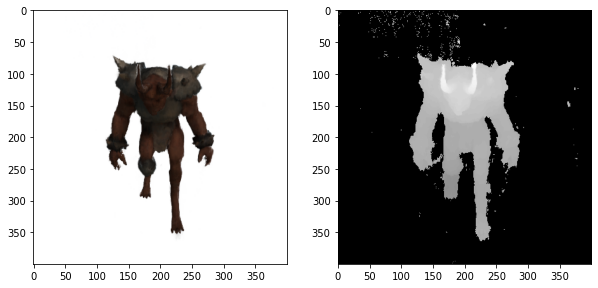

In [18]:
# Rendering - images
# just one image
# set render params
torch.set_default_tensor_type('torch.cuda.FloatTensor')
args.no_reload = False # Train

hwf = [400, 400, 555.555]
_, render_kwargs_test, _, _, _ = create_nerf(args)
render_kwargs_test.update({'near' : 2., 'far' : 6.})

# I will print rgb, disps, accs
def generate_img(time, azimuth, elevation):
    assert 0. <= time <= 1.
    assert -180 <= azimuth <= 180
    assert -180 <= elevation <= 180
    
    render_poses = torch.unsqueeze(pose_spherical(azimuth, elevation, 4.0), 0).to(device)
    render_times = torch.Tensor([time]).to(device)

    with torch.no_grad():
            rgbs, disps = render_path(render_poses, render_times, hwf, args.chunk, render_kwargs_test, render_factor=args.render_factor)
    rgbs = to8b(rgbs)
    disps = to8b(disps)
    return rgbs[0], disps[0]

# genearte
time = 1.  # in [0,1]
azimuth = 180  # in [-180,180]
elevation = -20  # in [-180,180]
rgb, disp = generate_img(time, azimuth, elevation)

# shape checking
print(rgb.shape)
print(disp.shape)

# visualization
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(rgb)
ax2.imshow(disp, cmap='gray')
plt.show()

In [16]:
# Import module
import mcubes
import trimesh

# set render params
torch.set_default_tensor_type('torch.cuda.FloatTensor')
args.no_reload = False # Train

# testing
hwf = [400, 400, 555.555]
_, render_kwargs_test, _, _, _ = create_nerf(args)
render_kwargs_test.update({'near' : 2., 'far' : 6.})

# Reconstruction
time = 1.  # time in [0,1]
N = 256
min_rec, max_rec = -1.2, 1.2
t = np.linspace(min_rec, max_rec, N+1)

query_pts = np.stack(np.meshgrid(t, t, t), -1).astype(np.float32)
sh = query_pts.shape
pts = torch.Tensor(query_pts.reshape([-1,3]))

def reconstruct(points, time):
    net_fn = render_kwargs_test['network_query_fn']
    fn = lambda i0, i1 : net_fn(points[i0:i1,None,:], viewdirs=torch.zeros_like(points[i0:i1]), ts=torch.ones_like(points[i0:i1])[:,0:1]*time, network_fn=render_kwargs_test['network_fn'])
    chunk = 1024*64
    raw = np.concatenate([fn(i, i+chunk)[0].cpu().numpy() for i in range(0, points.shape[0], chunk)], 0)
    raw = np.reshape(raw, list(sh[:-1]) + [-1])
    sigma = np.maximum(raw[...,-1], 0.)
    return sigma
    
with torch.no_grad():
    sigma = reconstruct(pts, time)
    
# reconstruct
threshold = 40  # this is just a randomly found threshold
vertices, triangles = mcubes.marching_cubes(sigma, threshold)

# display
mesh = trimesh.Trimesh(vertices / N * (max_rec - min_rec) + min_rec , triangles)
mesh = trimesh.smoothing.filter_laplacian(mesh, iterations=3)
mesh.show()

NeRF type selected: D_NeRF
Found ckpts ['./logs\\hellwarrior\\800000.tar']
Reloading from ./logs\hellwarrior\800000.tar


In [12]:
# Make video
# Sava in (basedir + expname + ...)
torch.set_default_tensor_type('torch.cuda.FloatTensor')
args.no_reload = False
args.render_only = True
args.render_test = False
args.basedir = './logs'
args.dataset_type = 'blender'

for i in range(7):
    
    if i == 0:
        args.config = './configs/bouncingballs.txt'
        args.expname = 'bouncingballs'
        args.datadir = './data/bouncingballs/'
    
    elif i == 1:
        args.config = './configs/hellwarrior.txt'
        args.expname = 'hellwarrior'
        args.datadir = './data/hellwarrior/'
    
    elif i == 2:
        args.config = './configs/hook.txt'
        args.expname = 'hook'
        args.datadir = './data/hook/'
        
    elif i == 3:
        args.config = './configs/jumpingjacks.txt'
        args.expname = 'jumpingjacks'
        args.datadir = './data/jumpingjacks/'
    
    elif i == 4:
        args.config = './configs/lego.txt'
        args.expname = 'lego'
        args.datadir = './data/lego/'
        
    elif i == 5:
        args.config = './configs/mutant.txt'
        args.expname = 'mutant'
        args.datadir = './data/mutant/'
    
    train(args)

C:\Users\Admin\AppData\Local\Temp\ipykernel_6268\2345252433.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs.append(imageio.imread(fname))


Loaded blender (190, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] ./data/bouncingballs/
NeRF type selected: D_NeRF
Found ckpts ['./logs\\bouncingballs\\800000.tar']
Reloading from ./logs\bouncingballs\800000.tar
RENDER ONLY
test poses shape torch.Size([40, 4, 4])


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\aimv\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [14:19<00:00, 21.48s/it]


Done rendering ./logs\bouncingballs\renderonly_path_799999
Loaded blender (140, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] ./data/hellwarrior/
NeRF type selected: D_NeRF
Found ckpts ['./logs\\hellwarrior\\800000.tar']
Reloading from ./logs\hellwarrior\800000.tar
RENDER ONLY
test poses shape torch.Size([40, 4, 4])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [14:16<00:00, 21.41s/it]


Done rendering ./logs\hellwarrior\renderonly_path_799999
Loaded blender (140, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] ./data/hook/
NeRF type selected: D_NeRF
Found ckpts ['./logs\\hook\\800000.tar']
Reloading from ./logs\hook\800000.tar
RENDER ONLY
test poses shape torch.Size([40, 4, 4])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [14:20<00:00, 21.52s/it]


Done rendering ./logs\hook\renderonly_path_799999
Loaded blender (240, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] ./data/jumpingjacks/
NeRF type selected: D_NeRF
Found ckpts ['./logs\\jumpingjacks\\800000.tar']
Reloading from ./logs\jumpingjacks\800000.tar
RENDER ONLY
test poses shape torch.Size([40, 4, 4])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [14:16<00:00, 21.40s/it]


Done rendering ./logs\jumpingjacks\renderonly_path_799999
Loaded blender (81, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] ./data/lego/
NeRF type selected: D_NeRF
Found ckpts ['./logs\\lego\\800000.tar']
Reloading from ./logs\lego\800000.tar
RENDER ONLY
test poses shape torch.Size([40, 4, 4])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [14:21<00:00, 21.54s/it]


Done rendering ./logs\lego\renderonly_path_799999
Loaded blender (190, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] ./data/mutant/
NeRF type selected: D_NeRF
Found ckpts ['./logs\\mutant\\800000.tar']
Reloading from ./logs\mutant\800000.tar
RENDER ONLY
test poses shape torch.Size([40, 4, 4])


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [14:16<00:00, 21.42s/it]


Done rendering ./logs\mutant\renderonly_path_799999


FileNotFoundError: [Errno 2] No such file or directory: './data/standup/transforms_train.json'